# **Oficina 8: Usando técnicas e estratégias de análise de dados**

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Dados

In [2]:
# definido o número de registros 
num_registros = 1000
np.random.seed(42)

# Gerando dados aleatórios
dados = {
    "Idade": np.random.randint(18, 70, num_registros),
    "Sexo": np.random.choice(["M", "F"], num_registros),
    "Frequência de Compras": np.random.randint(1, 30, num_registros),
    "Categoria de Produtos": np.random.randint(1, 15, num_registros),
    "Total Gasto": np.round(np.random.uniform(50, 5000, num_registros), 2),
    "Descontos_Aproveitados": np.random.randint(0, 10, num_registros),
    "Tempo_na_Loja": np.random.uniform(5, 60, num_registros),
    "Satisfação": np.random.randint(1, 6, num_registros),  
}

# criando um DataFrame
df = pd.DataFrame(dados)
df.head()

,Idade,Sexo,Frequência de Compras,Categoria de Produtos,Total Gasto,Descontos_Aproveitados,Tempo_na_Loja,Satisfação
0,56,M,17,2,4552.65,0,11.951253,1
1,69,M,18,14,3362.54,4,6.531415,5
2,46,M,8,4,4154.97,6,39.250276,2
3,32,F,13,2,4400.95,7,49.371666,2
4,60,M,29,10,2880.27,9,51.310861,1


## Transformando valores categóricos em colunas com valores numéricos

In [3]:



# Crie uma instância do OneHotEncoder
onehotencoder = OneHotEncoder(categories='auto', sparse_output=False, dtype='int32')

# Aplicando a codificação one-hot na coluna 'Sexo'
ohe = onehotencoder.fit_transform(df[['Sexo']])

# Obtendo os nomes das categorias
categories = onehotencoder.categories_[0]

# Criando os nomes das colunas
column_names = [f"Sexo_{category}" for category in categories]

# Criando o DataFrame resultante com as colunas codificadas
ohe_df = pd.DataFrame(ohe, columns=column_names)
ohe_df

,Sexo_F,Sexo_M
0,0,1
1,0,1
2,0,1
3,1,0
4,0,1
...,...,...
995,1,0
996,0,1
997,1,0
998,0,1


In [4]:
# Concatenando os dois data frame em um só
df = pd.concat([df, ohe_df], axis=1)
# Removendo a coluna original 'Sexo'
df.drop(columns='Sexo', inplace=True)
# Exibindo as primeiras linhas do DataFrame
df.head()

,Idade,Frequência de Compras,Categoria de Produtos,Total Gasto,Descontos_Aproveitados,Tempo_na_Loja,Satisfação,Sexo_F,Sexo_M
0,56,17,2,4552.65,0,11.951253,1,0,1
1,69,18,14,3362.54,4,6.531415,5,0,1
2,46,8,4,4154.97,6,39.250276,2,0,1
3,32,13,2,4400.95,7,49.371666,2,1,0
4,60,29,10,2880.27,9,51.310861,1,0,1


In [5]:
# Removendo a coluna Sexo_M
df = df.drop(columns=["Sexo_M"])

## Padronizando os dados

In [6]:
# Normalizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

## Aplicando a Técnica PCA

In [7]:
# Aplique o PCA
pca = PCA(n_components=None)
pca.fit(df_scaled)

PCA()

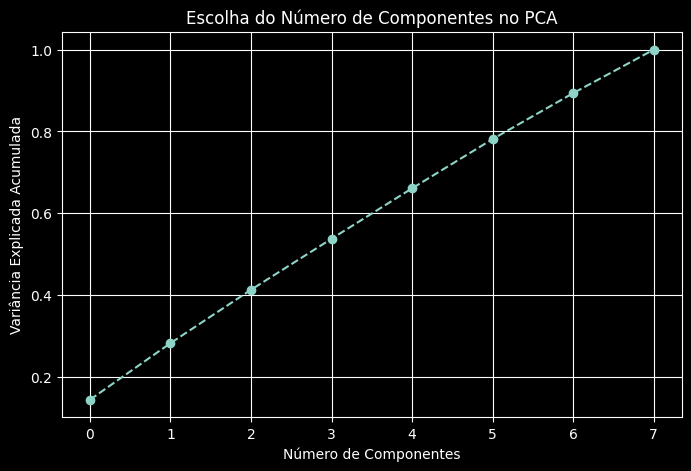

In [8]:
# Obtendo a variância explicada
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Escolha do Número de Componentes no PCA')
plt.grid()
plt.show()

In [9]:
# Escolhendo um número adequado de componentes (exemplo: 3 componentes principais)
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

In [10]:
# Criando um novo dataframe com os dados do pca
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca.head()

,PC1,PC2,PC3
0,-2.220344,1.304822,0.224666
1,1.072801,1.681131,2.398137
2,-0.966886,-0.399163,-0.263755
3,-0.476582,-1.915099,-0.960773
4,-1.068990,-0.351844,1.462442


In [11]:
# Criando as faixas para os componentes principais
df_pca['PC1_bin'] = pd.qcut(df_pca['PC1'], q=3, labels=["Baixo", "Médio", "Alto"])
df_pca['PC2_bin'] = pd.qcut(df_pca['PC2'], q=3, labels=["Baixo", "Médio", "Alto"])

## Método de Associação

In [12]:
# Convertendo as faixas para formato binário
df_encoded = pd.get_dummies(df_pca[['PC1_bin', 'PC2_bin']])

In [13]:
# Aplicando o método Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [14]:
# Visualizando as regras de associação
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PC2_bin_Médio),(PC1_bin_Baixo),0.333,0.333,0.115,0.345345,1.037073,1.0,0.004111,1.018858,0.053595,0.208711,0.018509,0.345345
1,(PC1_bin_Baixo),(PC2_bin_Médio),0.333,0.333,0.115,0.345345,1.037073,1.0,0.004111,1.018858,0.053595,0.208711,0.018509,0.345345
2,(PC2_bin_Alto),(PC1_bin_Baixo),0.334,0.333,0.113,0.338323,1.015986,1.0,0.001778,1.008045,0.023625,0.203971,0.007981,0.338831
3,(PC1_bin_Baixo),(PC2_bin_Alto),0.333,0.334,0.113,0.339339,1.015986,1.0,0.001778,1.008082,0.023590,0.203971,0.008017,0.338831
4,(PC1_bin_Médio),(PC2_bin_Alto),0.333,0.334,0.122,0.366366,1.096905,1.0,0.010778,1.051081,0.132450,0.223853,0.048598,0.365818


- Na técnica de redução de dimensionalidade, utilizei o PCA, pois ele reduz a complexidade antes da aplicação das regras de associação. Além disso, a redução de dimensionalidade acelera o processo de descoberta de padrões, e o PCA ajuda a eliminar redundâncias antes da identificação das associações.
- Eu escolhi o método Apriori porque é um dos algoritmos mais comuns e eficientes para descobrir regras de associação entre itens em conjuntos de dados transacionais.